In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PATH = os.getcwd()
import matplotlib.colors as mcolors
from importlib import reload
from ast import literal_eval
import codon_discr as cd
import CAI as cai
import codon_bias as cb
import utils
from consts import COLORS, BASE_SET

import check_genes_isolate_content as cg
import convert_to_numbers as ctn
from collections import Counter

TABLEU = mcolors.TABLEAU_COLORS
plt.style.use('ggplot')
reload(cd)
reload(cb)
reload(ctn)
reload(cg)
colors = TABLEU.keys()

In [6]:
# Applying literal_eval to all list columns

org_df = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'final.csv'))
org_df.Gene_order = org_df.Gene_order.apply(literal_eval)
org_df.Notes = org_df.Notes.apply(literal_eval)
org_df.Gene_locations = org_df.Gene_locations.apply(literal_eval)
org_df_all = org_df.copy()
org_df = org_df.loc[org_df.not_valid == False, :]


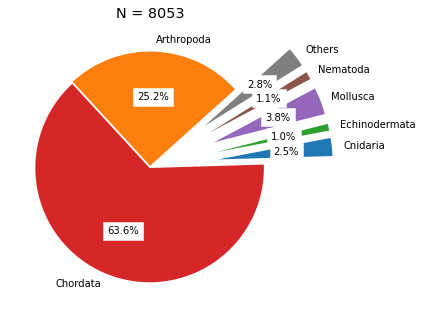

In [9]:
# Pie chart creation code.

phl_counts = org_df.groupby('phylum')[['Gene_order']].count().reset_index().sort_values(by = 'phylum').rename({'Gene_order':'counts'}, axis = 1)
phl_counts.loc[phl_counts.counts < 70, 'phylum'] = 'Others'
phl_counts = phl_counts.groupby('phylum')['counts'].sum()
explode = [0.6 if not i in ['Arthropoda', 'Chordata'] else 0.01 for i in phl_counts.index ]

phl_counts.plot(kind = 'pie', y = 'phylum', figsize = (6,6), explode = explode, startangle = 42, autopct = '%1.1f%%', shadow = False, title = f'N = {phl_counts.sum()}', colors = COLORS, ylabel = '', labeldistance = 1.1, radius = 1, rotatelabels = False, textprops = {'fontsize': 10, 'color':'black', 'backgroundcolor':'white'})
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'figures', 'fig_1a_piechart_dataset_dist.svg'), dpi = 300)

In [10]:
# Extra columns generated here:
# 'Gene_order' - list of genes in the order they appear in the genome
# 'Genes' - Amount of genes in the organism
# 'non_trna_Genes - Amount of genes that are not tRNA
# 'full_trna' - True/False if the organism has full tRNA
# 'atp8' - True/False if the organism has ATP8
# 'nad1' - True/False if the organism has NAD1
# 'atp8_len' - Length of the ATP8 gene
# 'atp6_len' - Length of the ATP6 gene
# 'Gene_set' - Set of all unique genes in the organism
# 'missing_trna' - Set of all trna genes that the organism is missing (based on full set)
# 'Gene_order_nocodons' - List of genes in the order they appear in the genome without codons
# 'trna_set' - Set of all trna genes in the organism
# 'base_set' - True/False if the organism's tRNA genes are equal to the these in BASE_SET
# 'gene_set' - Set of all unique genes in the organism (without duplicate gene asterisks)

org_df['Genes'] = org_df.Gene_order.apply(lambda x : len(x))
org_df['non_trna_Genes'] = org_df.Gene_order.apply(lambda x : len([i for i in x if 'trn' not in i]))
org_df['trna_Genes'] = org_df.Gene_order.apply(lambda x : len([i for i in x if 'trn' in i]))
org_df['full_trna'] = org_df.Gene_order.apply(cg.full_trna_package)
org_df['atp8'] = org_df.Gene_order.apply(cg.check_gene, gene = 'atp8')
org_df['nad1'] = org_df.Gene_order.apply(cg.check_gene, gene = 'nad1')

org_df['atp8_len'] = org_df.apply(cg.check_gene_length, gene = 'atp8', axis = 1)
org_df['atp6_len'] = org_df.apply(cg.check_gene_length, gene = 'atp6', axis = 1)
org_df['Gene_set'] = org_df.Gene_order.apply(cg.to_set)
org_df['missing_trna'] = org_df.Gene_order.apply(cg.full_trna_package, return_missing = True)
org_df['Gene_order_nocodons'] = org_df.Gene_order.apply(ctn.remove_codon)
org_df['trna_set'] = org_df.Gene_order_nocodons.apply(
    lambda x : cg.to_set([i for i in x if 'trn' in i], keep_dups = True))
org_df['base_set'] = org_df.trna_set.apply(lambda x: x == BASE_SET)
org_df['gene_set'] = org_df.Gene_order_nocodons.apply(lambda x : cg.to_set(x))


In [13]:
# Import dataset with codons
#org_df_cod = pd.read_csv(os.path.join(PATH, 'DB_csvs', 'final_filtered_with_codons.csv'))
phs = ['Echinodermata', 'Mollusca', 'Nematoda', 'Chordata', 'Arthropoda']

In [14]:
# Generate the trna_match percentages
trna_match = org_df[org_df.phylum.isin(phs)].groupby('phylum').agg({'full_trna' : 'mean', 'missing_trna' : 'sum', 'Genes' : ['mean', 'std'], 'non_trna_Genes' : ['mean', 'std']}).reset_index()
trna_match['full_trna'] = trna_match['full_trna'] * 100
trna_match['most_missing'] = np.nan
trna_match['pct_missing'] = np.nan

for ph in phs:
    most_missing = Counter(trna_match.loc[trna_match.phylum == ph, 'missing_trna'].squeeze()).most_common(1)[0]
    trna_match.loc[trna_match.phylum == ph, 'most_missing'] = most_missing[0]
    trna_match.loc[trna_match.phylum == ph, 'pct_missing'] = (most_missing[1] / len(org_df.loc[org_df.phylum == ph, :])) * 100

trna_match = trna_match.sort_values('pct_missing')

In [15]:
#Non Cnidaria gene counts
non_cnid_genecount_mean = org_df[org_df.phylum != 'Cnidaria'].Genes.mean()
non_cnid_genecount_std = org_df[org_df.phylum != 'Cnidaria'].Genes.std()

print(f'Mean amount of genes : {non_cnid_genecount_mean}\nStandard deviation of genes : {non_cnid_genecount_std}')

Mean amount of genes : 36.95222321314817
Standard deviation of genes : 1.4244964284028931


In [16]:
#Cnidaria gene counts
cnid_genecount_mean = org_df[org_df.phylum == 'Cnidaria'].Genes.mean()
cnid_genecount_std = org_df[org_df.phylum == 'Cnidaria'].Genes.std()

print(f'Mean amount of genes : {cnid_genecount_mean}\nStandard deviation of genes : {cnid_genecount_std}')

Mean amount of genes : 17.230392156862745
Standard deviation of genes : 1.7841275670491412


In [17]:
#Cnidaria trnM and trnW
cnid = org_df[org_df.phylum == 'Cnidaria']
cnid_trnm = np.mean(cnid.Gene_order.apply(cg.check_gene, gene = 'trnM'))
cnid_trnw = np.mean(cnid.Gene_order.apply(cg.check_gene, gene = 'trnW'))

print(f'trnM is present in : {round(cnid_trnm * 100)}% of the cnidarians\ntrnW is present in : {round(cnid_trnw*100)}% of the cnidarians')

trnM is present in : 95% of the cnidarians
trnW is present in : 61% of the cnidarians


In [18]:
# Mean presence percentages of rrnS and rrnL
print(np.mean(org_df.Gene_order.apply(cg.check_gene, gene = 'rrnL')))
print(np.mean(org_df.Gene_order.apply(cg.check_gene, gene = 'rrnS')))

0.9944120203650814
0.994908729665963


In [19]:
org_df.groupby('class').count().tail(5)

,organism,RefSeq,kingdom,phylum,order,family,genus,Gene_order,Gene_locations,Notes,...,atp8,nad1,atp8_len,atp6_len,Gene_set,missing_trna,Gene_order_nocodons,trna_set,base_set,gene_set
class,,,,,,,,,,,,,,,,,,,,,
Tentaculata,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Thaliacea,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Trematoda,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Trichoplacidae,2,2,2,2,2,0,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Xenoturbellidae,10,10,10,10,10,0,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


In [20]:
# Check for the presence of ATP9 and add it as a column to org_df
org_df['ATP9'] = org_df.Gene_order.apply(cg.check_gene, gene = 'atp9')

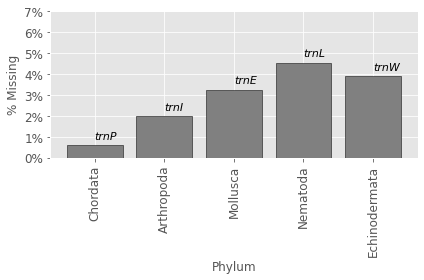

In [21]:
# Unused figure

colors =  ['tab:orange', 'tab:red', 'tab:green', 'tab:purple', 'tab:brown']
plt.bar(x = trna_match['phylum'].squeeze(), height = 100 - trna_match['full_trna'].squeeze(), color = 'grey', align = 'center', edgecolor = 'black')
plt.yticks(ticks = list(range(0,8,1)), labels = [f'{i}%' for i in range(0,8,1)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Phylum', fontsize = 12)
plt.ylabel('% Missing', fontsize = 12)
for _, row in trna_match.iterrows():
    plt.text(x = row.phylum.squeeze(), y = 100 - row.full_trna.squeeze() + 0.3, s = row.most_missing.squeeze(), fontsize = 11, fontstyle = 'oblique')
plt.ylim(0,7)
plt.tight_layout()

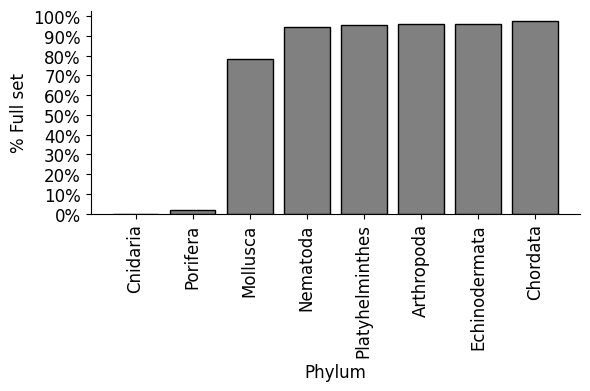

In [27]:
plt.style.use('default')
base_set = org_df.loc[org_df.phylum.isin(phs + ['Platyhelminthes', 'Cnidaria', 'Porifera']), :].groupby('phylum').agg({'base_set':'mean'}).reset_index().sort_values('base_set')
base_set['base_set'] = base_set['base_set'] * 100
colors =  ['tab:orange', 'tab:red', 'tab:green', 'tab:purple', 'tab:brown']
_, ax = plt.subplots(figsize = (6,4))
ax.bar(x = base_set['phylum'].squeeze(), height = base_set['base_set'], color = 'grey', align = 'center', edgecolor = 'black')
# Despine the top and right borders
sns.despine(top = True, right = True)
plt.yticks(ticks = list(range(0,101,10)), labels = [f'{i}%' for i in range(0,101,10)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Phylum', fontsize = 12)
plt.ylabel('% Full set', fontsize = 12)


plt.tight_layout()

plt.savefig(os.path.join(PATH, 'figures', 'fig_1d_pct_full_trna_set.svg'), dpi = 300)

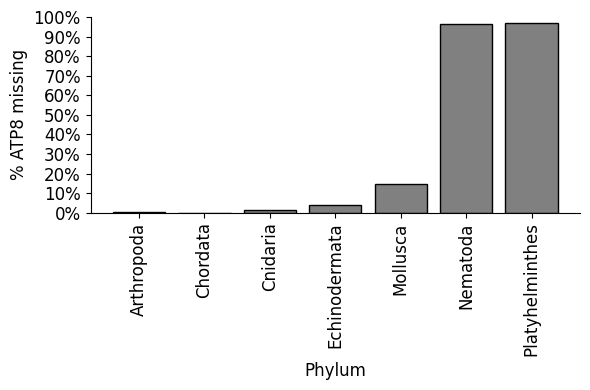

In [28]:
atp8 = org_df[org_df.phylum.isin(phs + ['Cnidaria', 'Platyhelminthes'])].groupby('phylum').agg({'atp8' : 'mean'}).reset_index()
atp8['atp8'] = atp8['atp8'] * 100
_, ax = plt.subplots(figsize = (6,4))

ax.bar(x = atp8['phylum'], height = 100 - atp8['atp8'].squeeze(), color = 'grey', align = 'center', edgecolor = 'black')
plt.yticks(ticks = list(range(0,101,10)), labels = [f'{i}%' for i in range(0,101,10)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Phylum', fontsize =12)
plt.ylabel('% ATP8 missing', fontsize = 12)
#for _, row in atp8.iterrows():
#    plt.text(x = row.phylum, y = row.atp8 - 1, s = row.most_missing, fontsize = 11, fontstyle = 'oblique')
plt.ylim(0,100)
# Despine the top and right borders
sns.despine(top = True, right = True)
plt.tight_layout()

plt.savefig(os.path.join(PATH, 'figures', 'fig_1c_pct_missing_atp8.svg'), dpi = 300)


In [35]:
# Count the prevalence of all unique tRNA gene sets
trna_set_per_ph = {}
for ph in org_df['class'].unique():
    trna_set_per_ph[ph] = utils.count_appearances(org_df, ph, level = 'class', col = 'trna_set')

In [37]:
phs = ['Annelida', 'Arthropoda', 'Chordata', 'Cnidaria', 'Echinodermata', 'Mollusca', 'Nematoda', 'Platyhelminthes', 'Porifera']
# Isolate them most common gene set within each phylum
ph_by_gset = org_df.groupby(['phylum', 'gene_set']).agg({'organism' : 'count'}).reset_index()
sum_in_ph = {i: sum(ph_by_gset[ph_by_gset.phylum == i].organism) for i in ph_by_gset.phylum.unique()}
# Convert the organism column to percentage within phylum
ph_by_gset['pct_in_ph'] = ph_by_gset.apply(lambda x: (x.organism / sum_in_ph[x.phylum]) * 100, axis = 1)
ph_by_gset = ph_by_gset.sort_values(by = 'pct_in_ph', ascending = False)[ph_by_gset.phylum.isin(phs)]
top_gset_per_ph = []
for ph in phs:
    top_gset_per_ph.append(ph_by_gset[ph_by_gset.phylum == ph].sort_values(by = 'pct_in_ph', ascending = False).gene_set.iloc[0])
ph_by_gset = ph_by_gset[ph_by_gset.gene_set.isin(top_gset_per_ph)].sort_values(by = 'pct_in_ph', ascending = False).drop_duplicates(subset = 'phylum', keep = 'first')

C:\Users\noam1\AppData\Local\Temp/ipykernel_2080/541247039.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ph_by_gset = ph_by_gset.sort_values(by = 'pct_in_ph', ascending = False)[ph_by_gset.phylum.isin(phs)]


In [38]:
# Grab the most prevalent gene set within each phylum, and the differences between it and chordata gene set
ph_by_gset['x_diff_from_chrd'] = ph_by_gset.gene_set.apply(lambda x : x.difference(ph_by_gset.loc[ph_by_gset['phylum'] == 'Chordata', 'gene_set'].squeeze())) # Difference from Chordata
ph_by_gset['chrd_diff_from_x'] = ph_by_gset.gene_set.apply(lambda x : ph_by_gset.loc[ph_by_gset['phylum'] == 'Chordata', 'gene_set'].squeeze().difference(x)) # Difference from Chordata
ph_by_gset.head(2)

,phylum,gene_set,organism,pct_in_ph,x_diff_from_chrd,chrd_diff_from_x
66,Chordata,"(trnL, trnI, nad5, nad3, nad4, rrnL, cox3, nad...",5063,98.790244,(),()
121,Platyhelminthes,"(trnL, trnI, nad5, nad3, nad4, rrnL, cox3, nad...",64,96.969697,(),(atp8)


In [39]:
ph_by_gset.loc[ph_by_gset['phylum'] == 'Cnidaria', 'chrd_diff_from_x'] = '-tRNAs'
ph_by_gset.loc[ph_by_gset['phylum'] == 'Porifera', 'chrd_diff_from_x'] = 'ATP9'
ph_by_gset.loc[ph_by_gset['phylum'] == 'Nematoda', 'chrd_diff_from_x'] = '-ATP8'
ph_by_gset.loc[ph_by_gset['phylum'] == 'Platyhelminthes', 'chrd_diff_from_x'] = '-ATP8'

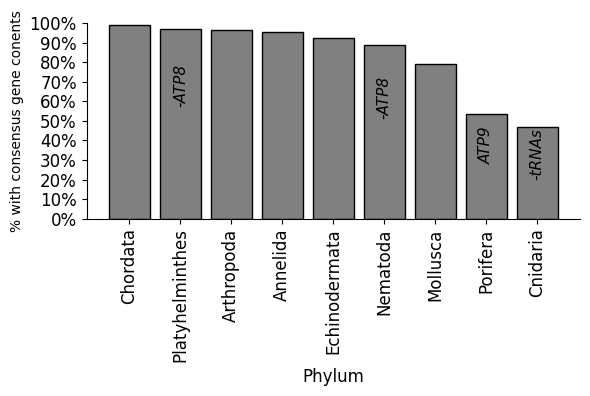

In [41]:
# UNUSED IN PAPER

_, ax = plt.subplots(figsize = (6,4))
ax.bar(x = ph_by_gset['phylum'], height = ph_by_gset['pct_in_ph'].squeeze(), color = 'grey', align = 'center', edgecolor = 'black')
sns.despine(top = True, right = True)
plt.yticks(ticks = list(range(0,101,10)), labels = [f'{i}%' for i in range(0,101,10)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Phylum', fontsize =12)
# Add label to each bar with the name of the difference from chordates
for _, row in ph_by_gset.iterrows():
    if type(row.chrd_diff_from_x) != frozenset:
        plt.text(x = row.phylum, y = row.pct_in_ph - row.pct_in_ph * .3, s = row.chrd_diff_from_x, fontsize = 11, fontstyle = 'oblique', rotation = 90, ha = 'center', va = 'center')
plt.ylabel('% with consensus gene conents', fontsize = 10)
plt.ylim(0,100)
plt.tight_layout()

In [49]:
# Supplementary figure S3 - The amount of different organisms per taxonomic group
per_ph = org_df_all.groupby('phylum').agg({'organism' : 'count'}).reset_index()
per_ph = per_ph.sort_values(by = 'phylum', ascending = True)


In [50]:
per_chord_class = org_df_all[org_df_all.phylum == 'Chordata'].groupby('class').agg({'organism' : 'count'}).reset_index()
per_chord_class.sort_values(by = 'organism', ascending = True)

,class,organism
6,Coelacanthimorpha,2
12,Myxini,2
13,Thaliacea,3
7,Dipnoi,5
10,Leptocardii,9
8,Hyperoartia,11
5,Cladistia,13
2,Ascidiacea,20
4,Chondrichthyes,163
9,Lepidosauria,243


,phylum,order
6,Chordata,17.0
13,Mollusca,11.0
19,Platyhelminthes,8.0
1,Annelida,7.0
9,Echinodermata,7.0
20,Porifera,6.0
2,Arthropoda,6.0
7,Cnidaria,4.0
10,Entoprocta,2.0
8,Ctenophora,2.0


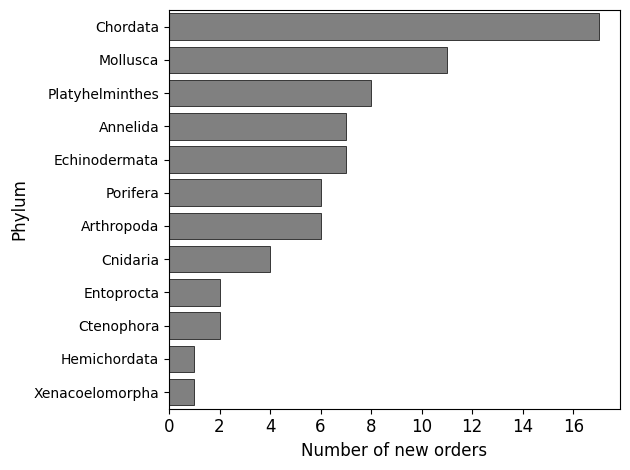

In [52]:
# Number of new taxonomic orders in each phylum as compared to MitoZoa
mitozoa = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'MitoZoa.csv'), index_col = 0)
mitozoa_grouped = mitozoa.drop_duplicates(subset = 'organism', keep = 'first').groupby(['phylum']).agg({'order' : 'nunique'}).sort_index()
org_db_grouped = org_df.drop_duplicates(subset = 'organism', keep = 'first').groupby(['phylum']).agg({'order' : 'nunique'}).sort_index()

diff = org_db_grouped - mitozoa_grouped
diff = diff.reset_index().sort_values(by = 'order', ascending = False)
diff = diff[diff['order'] > 0]
display(diff)

sns.barplot(x = 'order', y = 'phylum', dodge = False,data = diff, edgecolor = 'black', linewidth = .5, color = 'grey')
plt.xticks( fontsize = 12)
plt.ylabel('Phylum', fontsize = 12)
plt.xlabel('Number of new orders', fontsize = 12)
plt.tight_layout()


In [54]:
org_df_all[~(org_df_all.organism.isin(mitozoa.organism))][['organism', 'RefSeq', 'genus', 'family', 'order', 'class', 'phylum']].rename({'RefSeq' : 'accession'}, axis = 1).rename({i:i.capitalize() for i in ['accession', 'organism', 'RefSeq', 'genus', 'family', 'order', 'class', 'phylum']}, axis = 1).to_excel(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs','orgs_not_in_mitozoa.xlsx'), sheet_name = 'S4', index = False)

In [ ]:
reload(cd)
reload(utils)

rscu = utils.row_iter_to_df(org_df, cd.calculate_relative_adapt)
rscu.columns
rscu.to_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'all_rscu_filtered'), index = False)

In [76]:
org_df.to_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'final_filtered.csv'), index = False)